# Final Project Part 3 - Cheri Hung


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
from pandas.io import sql
from math import sqrt
import sqlite3
from hung_func import *
from sklearn import feature_selection, linear_model, metrics, model_selection
plt.style.use('ggplot')

wd = 'assets/'
db_conn = sqlite3.connect(wd+'dev_hung.db')
print db_conn

## I. Exploratory Analysis

### Dataset 1: Ideal Cost vs Actual Cost

In [2]:
#create dataframe of the main dataset of a SQL View 
df_IvAC_raw = sql.read_sql(
    'SELECT V.ProductID, COUNT(V.InventoryID), I.ProductDescription, SUM(V.VarianceQty), \
    D.Date, IC.CategoryID, C.Category, I.ProductType, D.StoreID \
  FROM [InventoryDates] D \
  INNER JOIN [IVActualC] V ON D.InventoryId = V.InventoryID \
  INNER JOIN [Ingredients] I ON I.ProductID = V.ProductID \
  JOIN [ItemCategories] IC ON IC.ProductID = V.ProductID \
  JOIN [Categories] C ON C.CategoryID = IC.CategoryID \
  GROUP BY V.ProductID', con=db_conn)

In [3]:
#df_IvAC_raw = sql.read_sql('SELECT * FROM vw_IVActualC_inventoryTotal', con=db_conn)
df_IvAC = df_IvAC_raw.dropna()
df_IvAC.head(1)

,ProductID,COUNT(V.InventoryID),ProductDescription,SUM(V.VarianceQty),Date,CategoryID,Category,ProductType,StoreID
0,24,20,"Tomato, Cherry",951.0,11/16/16 0:00,2,Produce,2,6


In [4]:
#change column names to be readable
df_IvAC.columns = ['ProductID', 'TotalOrders', 'Name', 'VarianceQty', 'Date', 'CategoryID', 'Category', 'ProductType', 'StoreID']

In [5]:
df_IvAC.head(3)

,ProductID,TotalOrders,Name,VarianceQty,Date,CategoryID,Category,ProductType,StoreID
0,24,20,"Tomato, Cherry",951.000,11/16/16 0:00,2,Produce,2,6
1,26,6,Tito's Vodka,-66.556,12/16/16 0:00,11,Liquor,1,15
2,37,3,Sutter Home Cabernet Sauvignon,10.144,11/28/16 0:00,10,Wine,1,15


| Variable | Description | Type of Variable |
|----------|:-------------:|------:|
| ProductID |Identifying ingredient ID | discrete numerical ID |
| TotalOrders |number of inventory orders placed | continous numerical |
| Name | Ingredient name | text |
| VarianceQty | Difference between ActualQty and IdealQty as calculated by the system | continous numerical |
| Date | Inventory order date | discrete numerical ID |
| CategoryID | category id | discrete numerical ID |
| Category | category the ingredient belongs to | text |
| ProductType | a general product type. 1=liquor, 2=food, 3=other, 4=merchandise | discrete numerical ID |
| StoreID | store that data is associated with | discrete numerical ID |


In [6]:
#print categories for reference
df_categories = sql.read_sql('SELECT CategoryID, Category FROM Categories', con=db_conn)
df_categories

,CategoryID,Category
0,0,NOT ASSIGNED
1,1,Meat
2,2,Produce
3,3,Dairy
4,4,Other Food
5,5,Seafood
6,6,Poultry
7,7,Bread
8,8,NA Beverage
9,9,Beer


In [7]:
ivac_foods = df_IvAC[df_IvAC['ProductType'] == '2']
ivac_foods.head()

,ProductID,TotalOrders,Name,VarianceQty,Date,CategoryID,Category,ProductType,StoreID
0,24,20,"Tomato, Cherry",951.000,11/16/16 0:00,2,Produce,2,6
3,38,17,"Sugar, Bulk",658.030,10/27/16 0:00,4,Other Food,2,6
4,40,17,"Strawberries, Frozen",-337.440,10/27/16 0:00,4,Other Food,2,6
5,68,8,"Spice, Flour Seasoning",2.324,3/10/17 0:00,4,Other Food,2,5
6,80,19,Sour Cream,785.200,12/2/16 0:00,3,Dairy,2,7


In [8]:
ivac_foods.describe()

,ProductID,TotalOrders,VarianceQty,CategoryID,StoreID
count,49.000000,49.000000,49.000000,49.000000,49.000000
mean,374.734694,95.061224,15390.754918,3.653061,11.428571
std,145.458868,141.065648,50009.148872,2.890725,5.103104
min,24.000000,2.000000,-6576.000000,1.000000,4.000000
25%,292.000000,17.000000,-5.998000,2.000000,6.000000
50%,407.000000,36.000000,674.550000,4.000000,13.000000
75%,481.000000,103.000000,7498.912000,4.000000,15.000000
max,533.000000,671.000000,320904.181000,20.000000,19.000000


In [9]:
#take a look at the data by category in the Food (product type 2) group
ivac_foods_grouped = ivac_foods.groupby('CategoryID')
ivac_foods_grouped.size()

CategoryID
1     10
2      6
3      7
4     15
5      5
6      4
7      1
20     1
dtype: int64

Categories of food are fairly even in count.

### Variance Quantity - Main dataset

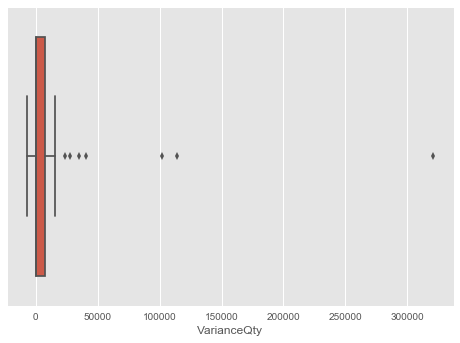

In [10]:
#variance quantity of the main dataset
varQty = ivac_foods.VarianceQty
sns.boxplot(varQty)

In [11]:
#a few significant outliers. Let's see what they are.
ivac_foods[ivac_foods.VarianceQty > 100000]
#ok, they are legitimate but just very highly used items with high quantity. will log transform it.

,ProductID,TotalOrders,Name,VarianceQty,Date,CategoryID,Category,ProductType,StoreID
47,399,287,"Fries, 5/16"" Russet",320904.181,3/17/17 0:00,4,Other Food,2,15
64,458,484,"Chicken, Tenderloins",102301.850,3/17/17 0:00,6,Poultry,2,15
65,459,671,"Chicken, Breasts",114368.310,3/24/17 0:00,6,Poultry,2,7


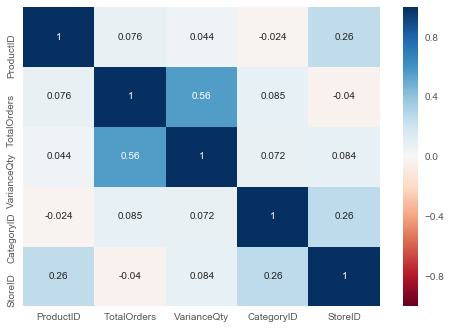

In [12]:
sns.heatmap(ivac_foods.corr(), annot=True, cmap='RdBu')

So it appears to have a moderate level of colinearity between VarianceQty and TotalOrders.

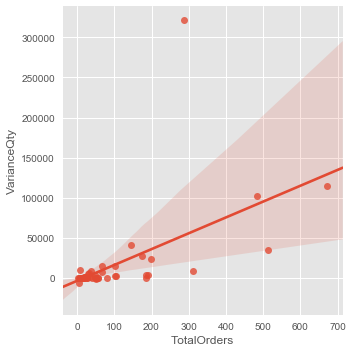

In [13]:
#ivac_foods_pos = ivac_foods[ivac_foods['VarianceQty'] > 0]
x = 'TotalOrders'
y = 'VarianceQty'
sns.lmplot(x, y, ivac_foods)

In [14]:
log_columns = ['VarianceQty', 'TotalOrders']
log_ivac_foods = log_transform(ivac_foods, log_columns)
log_ivac_foods.describe()

,ProductID,TotalOrders,VarianceQty,CategoryID,StoreID
count,36.000000,36.000000,36.000000,36.000000,36.000000
mean,365.027778,1.763402,3.334974,3.500000,11.250000
std,149.054062,0.543130,1.117016,1.681836,4.877792
min,24.000000,0.903090,0.366236,1.000000,4.000000
25%,290.750000,1.301030,2.611331,2.000000,6.000000
50%,405.000000,1.713986,3.462470,4.000000,13.000000
75%,471.250000,2.248483,4.065912,4.250000,15.000000
max,533.000000,2.826723,5.506375,7.000000,19.000000


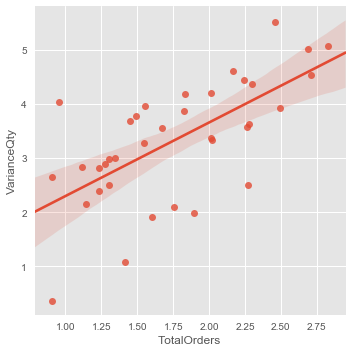

In [15]:
sns.lmplot(x, y, log_ivac_foods)

### Variance Quantity - Poultry Only with Actual Overage (i.e. VarianceQty > 0)

        ProductID  TotalOrders    VarianceQty  CategoryID    StoreID
count    4.000000     4.000000       4.000000         4.0   4.000000
mean   457.500000   338.250000   55340.635000         6.0  13.250000
std      1.290994   296.090499   61410.286263         0.0   4.193249
min    456.000000     8.000000     445.500000         6.0   7.000000
25%    456.750000   144.500000    3296.535000         6.0  13.000000
50%    457.500000   337.000000   53274.365000         6.0  15.000000
75%    458.250000   530.750000  105318.465000         6.0  15.250000
max    459.000000   671.000000  114368.310000         6.0  16.000000


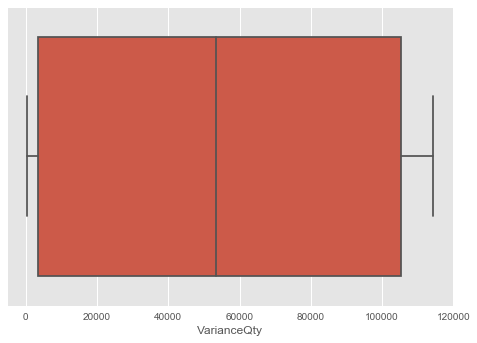

In [16]:
ivac_poultry = ivac_foods[ivac_foods['CategoryID'] == 6]
print ivac_poultry.describe()
varQty_poultry = ivac_poultry.VarianceQty
sns.boxplot(ivac_poultry.VarianceQty)

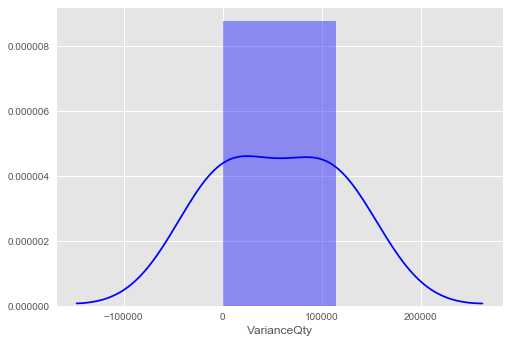

In [17]:
sns.distplot(varQty_poultry, color='blue', norm_hist=True)

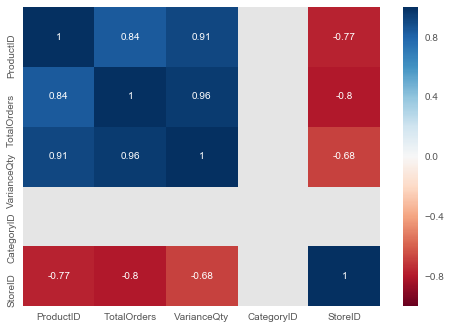

In [18]:
sns.heatmap(ivac_poultry.corr(), annot=True, cmap='RdBu')

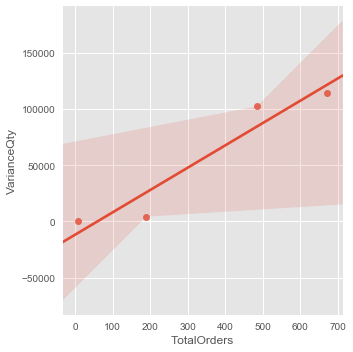

In [19]:
sns.lmplot(x, y, ivac_poultry)

In [20]:
log_ivac_poultry = log_transform(ivac_poultry, log_columns)
log_ivac_poultry.describe()

,ProductID,TotalOrders,VarianceQty,CategoryID,StoreID
count,4.000000,4.000000,4.000000,4.0,4.000000
mean,457.500000,2.173353,4.086277,6.0,13.250000
std,1.290994,0.878103,1.165339,0.0,4.193249
min,456.000000,0.903090,2.648848,6.0,7.000000
25%,456.750000,1.934838,3.383264,6.0,13.000000
50%,457.500000,2.481799,4.318977,6.0,15.000000
75%,458.250000,2.720315,5.021989,6.0,15.250000
max,459.000000,2.826723,5.058306,6.0,16.000000


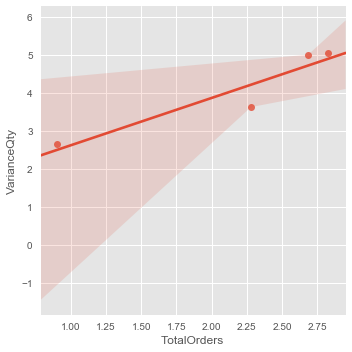

In [21]:
sns.lmplot(x, y, log_ivac_poultry)

### Regression Model on non-normalized data

P Values: [  3.25605350e-05]
Coefficients: [ 197.38732786]
y-intercept: -3373.12616655
R-2: 0.310014598267
MSE: 1690378600.03
RMSE: 41114.2140875


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

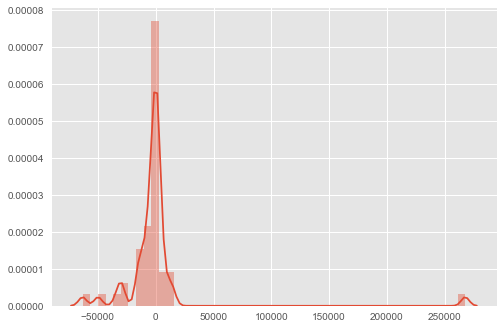

In [22]:
lmX = ivac_foods[[x]]
lmy = ivac_foods[y]
lm_int = linear_model.LinearRegression()
get_linear_model_metrics(lmX, lmy, lm_int)

P Values: [  3.25605350e-05]
Coefficients: [ 186.14817451]
y-intercept: 0.0
R-2: 0.306841332933
MSE: 1698152706.27
RMSE: 41208.6484402


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

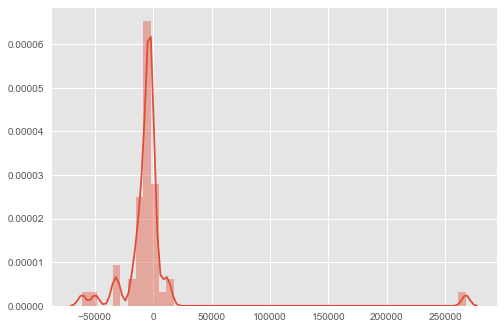

In [23]:
lm_noint = linear_model.LinearRegression(fit_intercept = False)
get_linear_model_metrics(lmX, lmy, lm_noint)

### Regression Model based on Logged Transform Data

P Values: [  1.17938190e-05]
Coefficients: [ 1.35786861]
y-intercept: 0.940505779505
R-2: 0.435918085351
MSE: 0.684267962081
RMSE: 0.827204909367


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

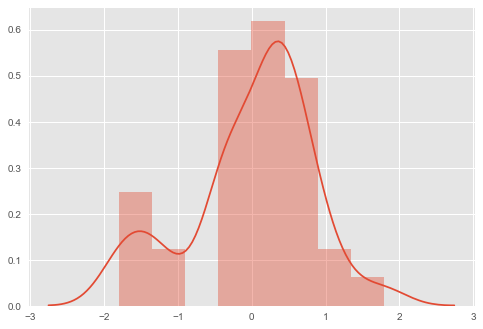

In [24]:
logX = log_ivac_foods[[x]]
logy = log_ivac_foods[y]
lm_int = linear_model.LinearRegression()
get_linear_model_metrics(logX, logy, lm_int)

### Try Different Estimators to Find a Better Regression Model
Use Logged Transform data because it performed better

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
P Values: [  1.17938190e-05]
Coefficients: [ 1.23796495]
y-intercept: 1.15194409128
R-2: 0.43251906123
MSE: 0.688391198882
RMSE: 0.829693436687

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)
P Values: [  1.17938190e-05]
Coefficients: [ 1.29949423]
y-intercept: 1.16273483421
R-2: 0.42338144698
MSE: 0.699475717847
RMSE: 0.836346649331

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
P Values: [  1.17938190e-05]
Coefficients: [ 1.35786861]
y-intercept: 0.940505779505
R-2: 0.435918085351
MSE: 0.684267962081
RMSE: 0.827204909367

RidgeCV(alphas=array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.

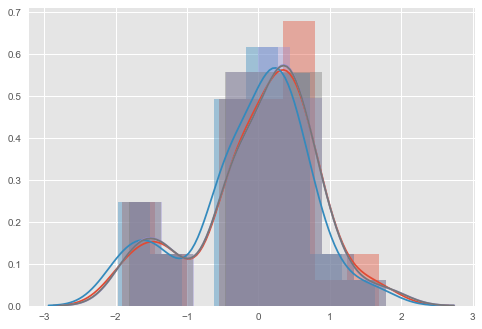

In [50]:
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
epsilons = np.arange(1.1, 1.5, 1.8)

estimators = [
    linear_model.Ridge(),
    linear_model.HuberRegressor(),
    linear_model.LinearRegression(),
    linear_model.RidgeCV(scoring='neg_mean_squared_error', alphas=(np.logspace(-10, 10, 21)))
]

for est in estimators:
    print est
    get_linear_model_metrics(logX, logy, est)
    print

### Tweak using Ridge Estimator to see if we can get fix a higher R-Squared score

In [42]:
gs = model_selection.GridSearchCV(
    estimator=linear_model.Ridge(),
    param_grid={'alpha': alphas},
    # Default score is R-squared
    scoring='neg_mean_squared_error',
    cv = 5)

gs.fit(logX, logy)
print gs.best_estimator_
print gs.best_params_
print -gs.best_score_

Ridge(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)
{'alpha': 0.10000000000000001}
0.902022895945


In [43]:
gsHub = model_selection.GridSearchCV(
    estimator=linear_model.HuberRegressor(),
    param_grid={'alpha': alphas, 'epsilon': epsilons},
    # Default score is R-squared
    #scoring='neg_mean_squared_error',
    cv = 5)

gsHub.fit(logX, logy)
print gsHub.best_estimator_
print gsHub.best_params_
print -gsHub.best_score_

HuberRegressor(alpha=1.0, epsilon=1.1000000000000001, fit_intercept=True,
        max_iter=100, tol=1e-05, warm_start=False)
{'alpha': 1.0, 'epsilon': 1.1000000000000001}
0.767499746494


P Values: [  1.17938190e-05]
Coefficients: [ 1.34484307]
y-intercept: 0.96347503626
R-2: 0.435877972756
MSE: 0.684316621262
RMSE: 0.827234320651


Ridge(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

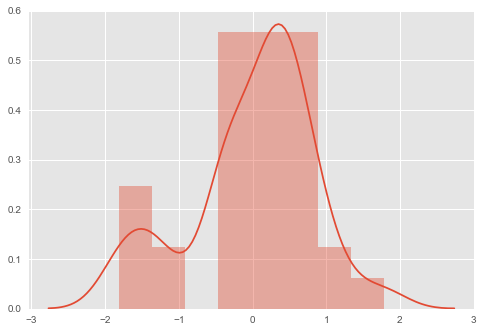

In [44]:
get_linear_model_metrics(logX, logy, gs.best_estimator_)

P Values: [  1.17938190e-05]
Coefficients: [ 1.23140765]
y-intercept: 1.36019199398
R-2: 0.400246917504
MSE: 0.727539403151
RMSE: 0.852959203685


HuberRegressor(alpha=1.0, epsilon=1.1000000000000001, fit_intercept=True,
        max_iter=100, tol=1e-05, warm_start=False)

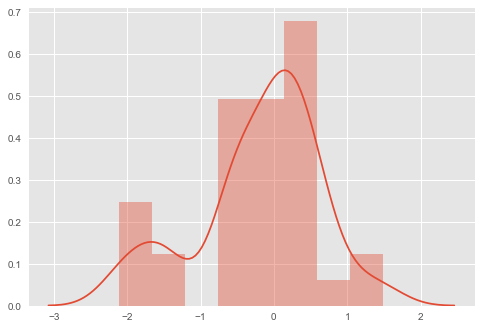

In [40]:
get_linear_model_metrics(logX, logy, gsHub.best_estimator_)